# Imports and Definitions

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from shapely.geometry import Point, LineString
import requests
import contextily as ctx
from bs4 import BeautifulSoup
import os
import re
import time
import cProfile
from tqdm import tqdm
from numba import njit, prange

from Webtris import MIDAS
from Webtris.utils import plot_report, show_sites, plot_map

sns.set_style("white")
%load_ext lab_black

# MIDAS sites (Motorway Incident Detection and Automatic Signalling)

In [3]:
midas = MIDAS(version=1.0)

### MIDAS sites locations

In [111]:
midas_sites = midas.sites()

In [6]:
len(midas_sites["link"].unique())

2794

In [175]:
midas_sites.groupby(["link"]).size().sort_values(ascending=False)

link
102004801    42
102004601    41
200047941    31
108018902    29
123008901    29
             ..
199095501     1
115020301     1
115020401     1
115020501     1
101000501     1
Length: 2794, dtype: int64

In [ ]:
# example links

In [136]:
sites_199055701 = ",".join(midas_sites[midas_sites["link"] == "199055701"].Id.values)

In [176]:
sites_102004801 = ",".join(midas_sites[midas_sites["link"] == "102004801"].Id.values)

In [137]:
df_199055701 = midas.daily_report(
    start="31-10-2016", end="04-11-2016", sites=sites_199055701
)

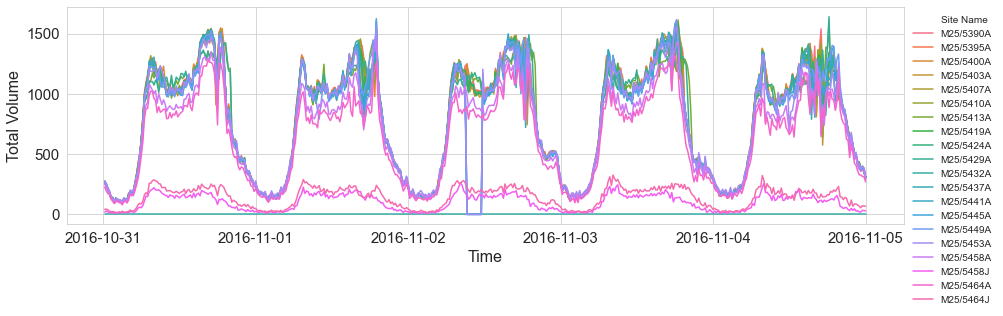

In [115]:
plot_report(df_199055701)

> approach for anomaly detection or malfunctioning site
windowed correlation for sensors in a link.
Median absolute deviation

In [214]:
from scipy.stats import ks_2samp

In [222]:
df_f = pd.DataFrame(index=df_piv.columns, columns=df_piv.columns)

In [241]:
for col_i in df_piv.columns:
    for col_j in df_piv.columns:
        df_f.loc[col_i, col_j] = float(
            ks_2samp(df_piv[col_i].values, df_piv[col_j].values)[1]
        )

/Users/markd/projects/he/he/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning:

invalid value encountered in less_equal



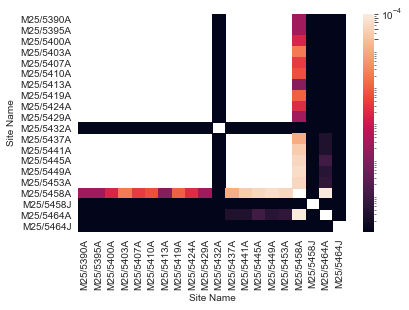

In [279]:
from matplotlib.colors import LogNorm

sns.heatmap(
    df_f[df_f < 0.01].astype(float), norm=LogNorm(), vmin=10 ** -10, vmax=10 ** -4
)

In [219]:
df_piv = (
    df_199055701[["Site Name", "Total Volume", "time"]]
    .pivot(index="time", columns="Site Name", values="Total Volume")
    .fillna(0)
)

In [ ]:
# df_199055701[["Site Name", "Total Volume", "time"]].pivot(
#     index="time", columns="Site Name", values="Total Volume"
# ).fillna(0).corr()

> MIDAS Sites within the same link, drastically different volumes

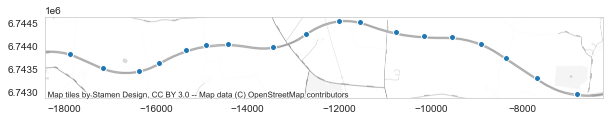

In [117]:
show_sites(
    midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].unique())],
    backend="geopandas",
)

In [7]:
show_sites(
    midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].values)],
    backend="mapbox",
)

NameError: name 'df_199055701' is not defined

In [193]:
df_102004801 = midas.daily_report(
    start="01-11-2019",
    end="04-11-2019",
    sites="179,314,319,466,502,685,874,1278,1334,1470,1692",
)

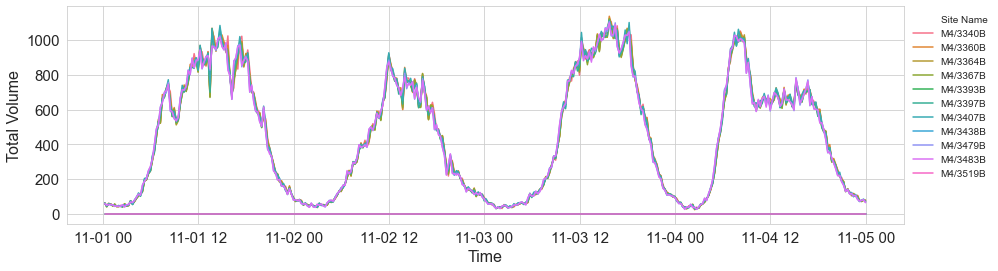

In [196]:
plot_report(df_102004801)

### Random sites example

In [109]:
df = midas.daily_report(start="01-11-2016", end="05-11-2016", sites="1,2,3,5,6")

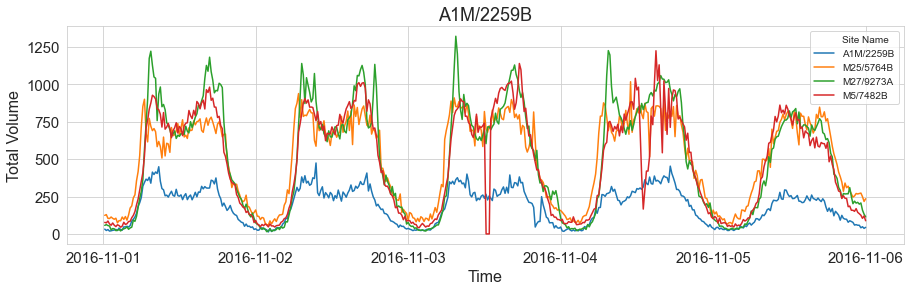

In [110]:
plot_report(df)

# NTIS model

In [3]:
import xml.etree.ElementTree as ET

ntis_file = "NTISModel-PredefinedLocations-2020-03-31-v12.0.xml"

tree = ET.parse(ntis_file)
root = tree.getroot()

namespaces = {"ntis": "http://datex2.eu/schema/2/2_0"}  # add more as needed

In [4]:
def to_float(text):
    try:
        return float(text)
    except:
        return np.nan


def get_text(link, tag):
    elements = link.findall(f".//ntis:{tag}", namespaces)
    if len(elements) > 1:
        return [el.text for el in elements]
    elif elements:
        return elements[0].text


def get_value(link, tag):
    elements = link.findall(f".//ntis:{tag}", namespaces)
    if len(elements) > 1:
        return [to_float(el.text) for el in elements]
    elif elements:
        return to_float(elements[0].text)


def get_location_description(link):
    return {
        "location": link.findall(
            f".//ntis:predefinedLocationName/ntis:values/ntis:value", namespaces
        )[0].text
    }


def get_area_cols(link):
    """
    Get area information
    """
    area_descriptors = link.findall(f".//ntis:areaDescriptor", namespaces)

    county = get_text(area_descriptors[0], "value")
    area_team = get_text(area_descriptors[1], "value")
    regional_control_centre = get_text(area_descriptors[0], "value")

    return {
        "county": county,
        "area_team": area_team,
        "regional_control_centre": regional_control_centre,
    }


def get_nodes(link):
    """
    Get start and end nodes IDs for link
    """
    start_node = get_text(link, "fromPoint/ntis:fromReferent/ntis:referentIdentifier",)
    end_node = get_text(link, "toPoint/ntis:fromReferent/ntis:referentIdentifier",)
    return {"start_node": start_node, "end_node": end_node}

In [19]:
def ntis_links():
    """
    Get NTIS link metadata
    """

    # all link elements
    links = list(
        root.findall(
            ".//*ntis:predefinedLocationContainer[@id='NTIS_Network_Links']", namespaces
        )[0]
    )

    # mapping columns to individual tags
    text_cols = {
        "carriageway": "carriageway",
        "direction": "directionBoundOnLinearSection",
        "roadnumber": "roadNumber",
    }

    numeric_cols = {
        "length": "lengthAffected",
        "mid_point_capacity": "midPointStaticCapacity",
        "exit_point_capacity": "exitPointStaticCapacity",
    }

    links_vals = []

    for i in tqdm(prange(len(links))):
        link = links[i]
        link_dict = {}

        # link_id
        link_dict.update({"id": link.get("id")})

        # location description
        link_dict.update(get_location_description(link))

        # area information
        link_dict.update(get_area_cols(link))

        # text columns tags
        for col in text_cols:
            link_dict.update({col: get_text(link, text_cols[col])})

        # numeric columns tags
        for col in numeric_cols:
            link_dict.update({col: get_value(link, numeric_cols[col])})

        # start and end node
        link_dict.update(get_nodes(link))

        # add to list of links
        links_vals.append(link_dict)

    print(f"Number of links found: {len(links_vals)}")

    return pd.DataFrame(links_vals)


def NTIS_shapes() -> gpd.GeoDataFrame():
    """
    Get NTIS links shapes
    - link_id
    - linestring geometry
    """
    ntis_links_shapes = []
    for elem in root.findall(".//*ntis:predefinedLocationContainer", namespaces):
        if "NTIS_Link_Shape" in elem.get("id"):
            ntis_links_shapes.append(elem)

    link_vals = []
    for i in tqdm(range(len(ntis_links_shapes))):
        link = ntis_links_shapes[i]
        lats = []
        longs = []
        link_id = link.get("id").split("_")[-1]
        lats = get_value(link, "latitude")
        longs = get_value(link, "longitude")
        link_vals.append(
            {"link_id": link_id, "geometry": LineString(list(zip(longs, lats)))}
        )
    print(f"Number of links found: {len(link_vals)}")
    return gpd.GeoDataFrame(link_vals, crs="epsg:4326")


def NTIS_nodes() -> gpd.GeoDataFrame:
    """
    Get NTIS network nodes with point geometry
    for each node:
    - node_id
    - longitude
    - latitude
    - geometry
    """
    nodes = root.findall(
        ".//*ntis:predefinedLocationContainer[@id='NTIS_Network_Nodes']/ntis:predefinedLocation",
        namespaces,
    )

    nodes_vals = []
    for i in tqdm(range(len(nodes))):
        node = nodes[i]
        node_id = node.get("id")
        lat = get_value(node, "latitude")
        long = get_value(node, "longitude")
        nodes_vals.append(
            {
                "node_id": node_id,
                "Longitude": long,
                "Latitude": lat,
                "geometry": Point(long, lat),
            }
        )

    print(f"Number of nodes found: {len(nodes_vals)}")
    return gpd.GeoDataFrame(nodes_vals, crs="epsg:4326")


def HATRIS_sections():
    """
    Get hatris sections
    - section_id
    - NTIS links ids
    """
    hatris_sections = []
    for elem in root.findall(".//*ntis:predefinedLocationContainer", namespaces):
        if "NTIS_HATRIS_Section" in elem.get("id"):
            hatris_sections.append(elem)

    hatris_vals = []
    for i in tqdm(range(len(hatris_sections))):
        sect = hatris_sections[i]
        section_id = sect.get("id").split("_")[-1]
        ntis_links = [
            link.get("id")
            for link in sect.findall(".//ntis:predefinedLocationReference", namespaces)
        ]
        hatris_vals.append({"section_id": section_id, "ntis_links": ntis_links})
    print(f"Number of sections found: {len(hatris_vals)}")
    return pd.DataFrame(hatris_vals)

In [8]:
df_ntis_links = ntis_links()

100%|██████████| 18592/18592 [00:01<00:00, 11033.56it/s]


Number of links found: 18592


In [9]:
gdf_ntis_shapes = NTIS_shapes()

100%|██████████| 18592/18592 [00:01<00:00, 14464.76it/s]

Number of links found: 18592


In [10]:
gdf_ntis_nodes = NTIS_nodes()

100%|██████████| 15831/15831 [00:00<00:00, 34775.55it/s]


Number of nodes found: 15831


In [20]:
df_hatris = HATRIS_sections()

100%|██████████| 2396/2396 [00:00<00:00, 129389.49it/s]

Number of sections found: 2396


123012901
123013001
199111903


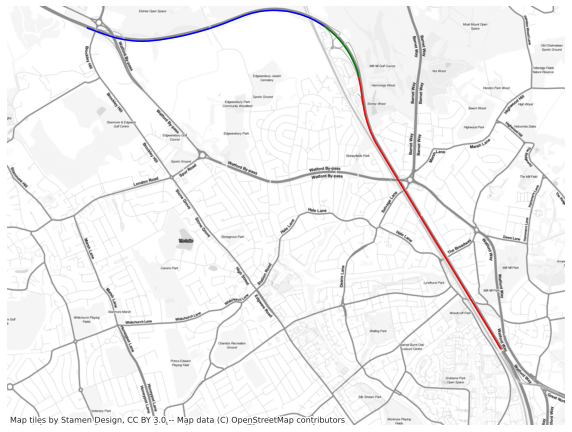

In [30]:
i = -1
fig, ax = plt.subplots(figsize=(10, 10))
colors = ["red", "green", "blue"]
for link in df_hatris.iloc[1]["ntis_links"]:
    print(link)
    i = i + 1
    plot_map(
        gdf_ntis_shapes[gdf_ntis_shapes["link_id"] == link], color=colors[i], ax=ax,
    )

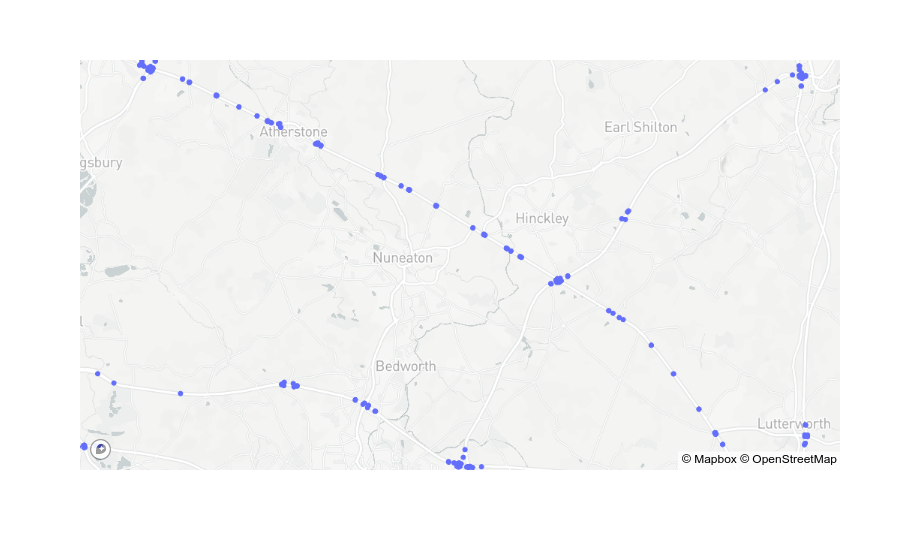

In [11]:
plot_map(gdf_ntis_nodes, markersize=5, color="gold", edgecolor="k", backend="mapbox")

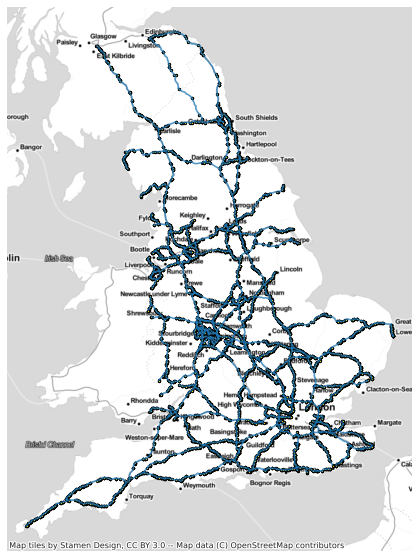

In [12]:
ax = plot_map(gdf_ntis_shapes, alpha=0.5)
plot_map(gdf_ntis_nodes, markersize=5, color="gold", edgecolor="k", ax=ax)

In [27]:
hatris_secs[0].get("id")

'NTIS_HATRIS_Section_HS50000001'

# Network models

In [125]:
hapms_file = "hapms/network20200302.shp"

In [126]:
hapms = gpd.read_file(hapms_file)

In [130]:
hapms.crs = "epsg:27700"

In [165]:
midas_buff = midas_sites[
    midas_sites["Description"].isin(df_199055701["Site Name"].unique())
].copy()
midas_buff["geometry"] = midas_buff["geometry"].buffer(5)
sites_hapms_join = gpd.sjoin(midas_buff, hapms, how="left", op="intersects")

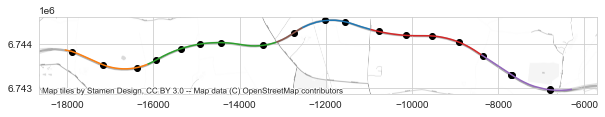

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
i = -1
for sect in sites_hapms_join["sect_label"].unique():
    i = i + 1
    hapms[hapms["sect_label"].isin([sect])].to_crs("epsg:3857").plot(
        ax=ax, color=sns.color_palette()[i]
    )
midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].unique())].to_crs(
    "epsg:3857"
).plot(ax=ax, color="k")
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

> multiple HAPMS sections in a single SRN link. \
This required a buffering of 5 meters ot match line segments with points
as the points are not exactly located to the road resolution

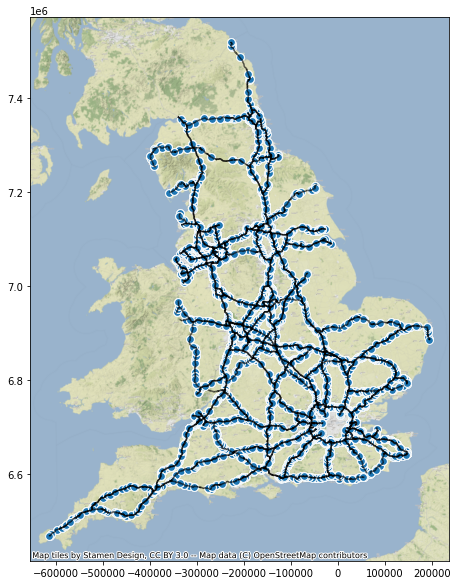

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sites_clean.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", alpha=1, markersize=60)
hapms_gdf.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

In [196]:
sites_clean_buff = sites_clean.copy()
sites_clean_buff["geometry"] = sites_clean_buff["geometry"].buffer(10)
sites_hapms_join = gpd.sjoin(sites_clean_buff, hapms_gdf, how="left", op="intersects")

In [197]:
midas_hapms = pd.merge(
    sites_clean, sites_hapms_join[["Id", "sect_label"]], on="Id", how="left"
)

In [202]:
sites_hapms_join[["sect_label", "location"]]

sect_label                                           location
1      0500A1M/298                                               None
2       1800M5/201  M5 Northbound. From Centre of Junction 7 Round...
2       1800M5/207               M5 Junction 7 Northbound Entry Slip.
3       1700M3/969  From start spur to J14 Chilworth MP 116.8 + 63...
4      1500M25/175  End of HRA over A127 to end of  NB slip on fro...
...            ...                                                ...
17842    4600M5/16  M5 Southbound. From start of Oldbury viaduct t...
17843  0600M62/180                    EB 34/0 (end of access) - 35/39
17844  4200M60/933  ACW link from M62 (starts at split to M60 CW -...
17845  0600M62/122                      EB 28/5+50 - 29/4+90 (c/l M6)
17845   0600M6/585  NB J21A B'ham/M'cr slip (Pineapple Bend) start...

[11954 rows x 2 columns]

In [200]:
midas_hapms[midas_hapms["sect_label"].isna()]

Id                                               Name Description  \
8         14  MIDAS site at A2/8392M priority 1 on link 2000...    A2/8392M   
150      170  MIDAS site at A2/8369J priority 1 on link 2000...    A2/8369J   
202      230  MIDAS site at M1/2463B priority 1 on link 1080...    M1/2463B   
223      259  MIDAS site at A2/8378L priority 1 on link 2000...    A2/8378L   
240      275  MIDAS site at M1/2389A priority 1 on link 2000...    M1/2389A   
...      ...                                                ...         ...   
11728  17880  MIDAS site at A1/2046A priority 1 on link 1240...    A1/2046A   
11733  17885  MIDAS site at A1/2018B priority 1 on link 2001...    A1/2018B   
11749  17899  MIDAS site at A1/2018A priority 1 on link 2001...    A1/2018A   
11750  17900  MIDAS site at A1/2021M priority 0 on link 1990...    A1/2021M   
11810  18071  MIDAS site at A1/2004L priority 1 on link 2001...    A1/2004L   

       Longitude   Latitude  Status       link    direction  \
8       0.381381  51.408466  Active  200045660    Westbound   
150     0.353038  51.417959  Active  200045742    Eastbound   
202    -0.418584  51.829537  Active  108022201   Southbound   
223     0.363333  51.414002  Active  200045674    Westbound   
240    -0.416364  51.763758  Active  200047643   Northbound   
...          ...        ...     ...        ...          ...   
11728  -0.252142  52.351802  Active  124000101   Northbound   
11733  -0.247101  52.327036  Active  200128513   Southbound   
11749  -0.247404  52.327176  Active  200128516   Northbound   
11750  -0.247304  52.329692  Active  199033702   Southbound   
11810  -0.243475  52.314844  Active  200128517   Southbound   

                            geometry sect_label  
8      POINT (565720.027 170406.050)        NaN  
150    POINT (563715.080 171398.004)        NaN  
202    POINT (509073.643 215728.883)        NaN  
223    POINT (564445.066 170981.016)        NaN  
240    POINT (509385.563 208416.785)        NaN  
...                              ...        ...  
11728  POINT (519144.330 274074.679)        NaN  
11733  POINT (519554.362 271328.598)        NaN  
11749  POINT (519533.361 271343.598)        NaN  
11750  POINT (519533.358 271623.604)        NaN  
11810  POINT (519834.380 269978.583)        NaN  

[238 rows x 10 columns]

In [210]:
fig, ax = plt.subplots(figsize=(20, 20))
sites_clean.loc[[10784]].to_crs("epsg:3857").plot(ax=ax)
midas_hapms.to_crs("epsg:3857").plot(ax=ax)
ctx.add_basemap(ax, zoom=10)

In [348]:
midas_hapms["geometry"] = midas_hapms["geometry"].buffer(100)

In [396]:
len(midas_hapms[~midas_hapms["sect_label"].isna()]) / len(midas_hapms)

0.24825513765025203

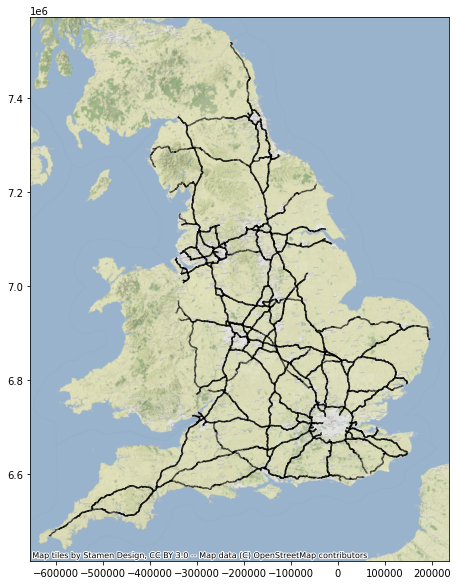

In [351]:
fig, ax = plt.subplots(figsize=(10, 10))
midas_hapms.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", color="blue", alpha=1)
hapms_gdf.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

# HATRIS

In [13]:
df_hatris = pd.read_csv("/Users/markd/projects/he/hatris.csv")


def start_pipe(df):
    return df.copy()


def clean(df):
    df.dropna(subset=["StartX"], inplace=True)
    return df


def create_geom(df):
    df["geometry"] = df.apply(
        lambda x: LineString([(x["StartX"], x["StartY"]), (x["EndX"], x["EndY"])]),
        axis=1,
    )

    return df


def convert_to_gdf(df):
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = "epsg:27700"
    return gdf

In [331]:
hatris_links = (
    df_hatris.pipe(start_pipe).pipe(clean).pipe(create_geom).pipe(convert_to_gdf)
)

(7400000.0, 7600000.0)

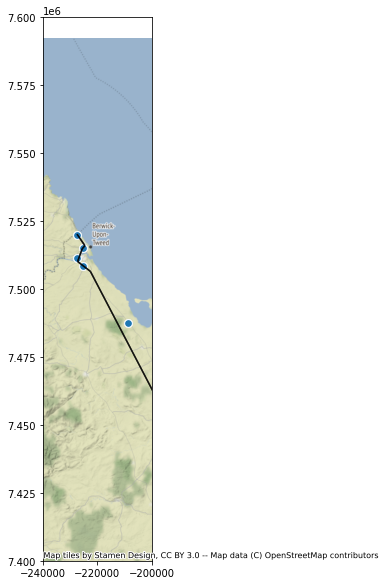

In [407]:
fig, ax = plt.subplots(figsize=(10, 10))
sites_clean.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", alpha=1, markersize=60)
hatris_links.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)
ax.set_xlim([-240000, -200000])
ax.set_ylim([7.4e6, 7.6e6])

In [403]:
sites_clean_buff = sites_clean.copy()
sites_clean_buff["geometry"] = sites_clean_buff["geometry"].buffer(100)
midas_hatris = gpd.sjoin(sites_clean_buff, hatris_links, how="left", op="intersects")

In [404]:
midas_hatris["geometry"] = midas_hatris["geometry"].buffer(5000)

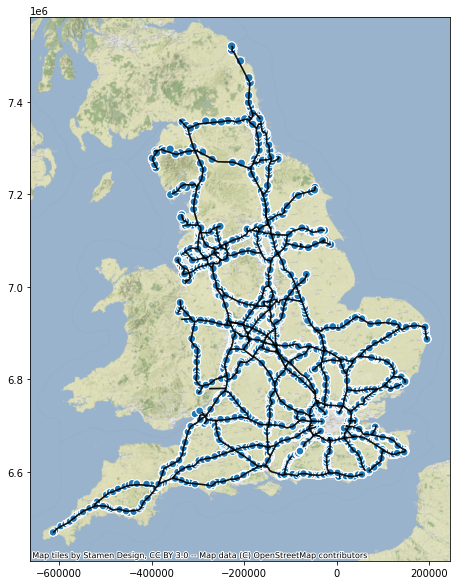

In [405]:
fig, ax = plt.subplots(figsize=(10, 10))
midas_hatris.to_crs("epsg:3857").plot(ax=ax, edgecolor="w")
hatris_links.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

In [402]:
print(len(midas_hatris))
print(len(midas_hatris[~midas_hatris["LinkRef"].isna()]))

12825
5882


# NTIS

## Selenium

In [ ]:
chromedriver = "/Users/markd/projects/he/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [188]:
p = re.compile("[a-zA-Z]\d+")

In [240]:
re.match(p, "A5183")

<re.Match object; span=(0, 5), match='A5183'>

In [227]:
df_links = pd.DataFrame()

In [231]:
roads = []

Empty DataFrame
Columns: []
Index: []

In [245]:
def get_href():
    # go to website click on link
    driver = webdriver.Chrome(chromedriver)
    url = "http://tris.highwaysengland.co.uk/detail/journeytimedata"
    driver.get(url)
    elems = driver.find_elements_by_xpath("//a[@href]")
    return elems, driver


def process(elems, driver, df_links):
    for elem in elems:
        if re.match(p, elem.text) and elem.text not in roads:
            print(elem.text)
            driver.find_element_by_link_text(elem.text).click()
            time.sleep(7)
            driver.find_element_by_xpath('//button[text()=" 2020"]').click()
            html_doc = driver.page_source

            soup = BeautifulSoup(html_doc, "html.parser")

            try:
                links_first_month_2020 = (
                    soup.find_all("button", text=" 2020")[0]
                    .next_element.next_element.next_element.find_all("table")[0]
                    .find_all("a", target="_blank")
                )
                for a in links_first_month_2020[:1]:
                    u = "http://tris.highwaysengland.co.uk" + a["href"]
                    df = pd.read_csv(
                        u, compression="zip", header=0, sep=",", quotechar='"'
                    )
                    df = df.drop_duplicates(subset=[" NTIS Link Number"], keep="first")
                    df_links = pd.concat([df_links, df])

            except:
                pass

            roads.append(elem.text)
            return True, df_links
    return False, df_links


while True:
    elems, driver = get_href()
    bl, df_links = process(elems, driver, df_links)
    if not bl:
        break

M606
M61
M62
M621
M65
M66
M67
M69
M6-TOLL
M74


In [247]:
df_links.to_csv("df_links.csv", index=False)

In [251]:
df_links = df_links[
    [
        " NTIS Link Number",
        " Road",
        " Carriageway",
        " NTIS Link Description",
        " NTIS Model Version",
        " Start Node Coordinates",
        " End Node Coordinates",
    ]
].copy()

In [252]:
df_links.head()

NTIS Link Number   Road    Carriageway  \
0          120014302     A1  entrySlipRoad   
0          200049762    A10     roundabout   
0          200075666  A1001     roundabout   
0          200052199  A1023     roundabout   
0          200005499  A1033     roundabout   

                               NTIS Link Description   NTIS Model Version  \
0  A1 northbound access at a minor junction betwe...                  1.0   
0                          roundabout at M25 J25/A10                  1.0   
0     A1001 northbound between A1(M) J2 and A1(M) J3                  1.0   
0              A1023 northbound between M25 and B186                  1.0   
0  A1033 eastbound at a minor junction between A6...                  1.0   

                    Start Node Coordinates  \
0  54.920707478275297 ; -1.612915462735710   
0  51.682682181170698 ; -0.050911278604530   
0  51.740848259774900 ; -0.238418793719917   
0   51.608514667537101 ; 0.264002470421456   
0  53.748488436610899 ; -0.284617107235886   

                      End Node Coordinates  
0  54.921472708741298 ; -1.619039785342490  
0  51.683488056159597 ; -0.050703064845945  
0  51.750885318343400 ; -0.243939235693910  
0   51.608818686159502 ; 0.265490831462923  
0  53.748375852469799 ; -0.284288037251645

In [254]:
df_links.columns = [col.strip() for col in df_links.columns]

In [256]:
from shapely.geometry import LineString

In [262]:
df_links.columns

Index(['NTIS Link Number', 'Road', 'Carriageway', 'NTIS Link Description',
       'NTIS Model Version', 'Start Node Coordinates', 'End Node Coordinates'],
      dtype='object')

In [272]:
df_links.head(1)

NTIS Link Number Road    Carriageway  \
0         120014302   A1  entrySlipRoad   

                               NTIS Link Description  NTIS Model Version  \
0  A1 northbound access at a minor junction betwe...                 1.0   

                    Start Node Coordinates  \
0  54.920707478275297 ; -1.612915462735710   

                      End Node Coordinates  \
0  54.921472708741298 ; -1.619039785342490   

                                            geometry  
0  LINESTRING (-1.61292 54.92071, -1.61904 54.92147)

In [264]:
def create_link(x):
    lat1 = float(x["Start Node Coordinates"].split(";")[0].strip())
    lon1 = float(x["Start Node Coordinates"].split(";")[1].strip())

    lat2 = float(x["End Node Coordinates"].split(";")[0].strip())
    lon2 = float(x["End Node Coordinates"].split(";")[1].strip())

    return LineString([(lon1, lat1), (lon2, lat2)])


df_links["geometry"] = df_links.apply(create_link, axis=1)

In [269]:
gdf_links = gpd.GeoDataFrame(df_links)
gdf_links.crs = "epsg:4326"
gdf_links = gdf_links.to_crs("epsg:27700")

In [20]:
gdf_links.plot(linewidth=7, figsize=(10, 10))

NameError: name 'gdf_links' is not defined